In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn
import copy as cp
import scipy.optimize as op
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()


import sys
sys.path.append('/home/yves/Documents/')
import pGPFA



In [2]:
nD = 3
y, params = pGPFA.genSim_data_static(n_neurons=89,
                                     nDims=nD,
                                     n_timePoints = 80,
                                     nTrials=3,
                                     pretty=False)

In [3]:
gpfa = pGPFA.model(data=y,
                   t=params['t'],
                   nDims=nD,
                   epsNoise=1e-3)

initialised! :)


In [5]:
gpfa.fit()

Running EM iteration 0 || log(L) after M step is: -16192897.48 ||  total time elapsed: 3.2s
Running EM iteration 1 || log(L) after M step is: -16192897.78 ||  total time elapsed: 5.7s
Running EM iteration 2 || log(L) after M step is: -16192897.42 ||  total time elapsed: 8.0s
Running EM iteration 3 || log(L) after M step is: -16192896.89 ||  total time elapsed: 10.4s
Running EM iteration 4 || log(L) after M step is: -16192895.79 ||  total time elapsed: 12.9s
Running EM iteration 5 || log(L) after M step is: -16192894.93 ||  total time elapsed: 15.2s
Running EM iteration 6 || log(L) after M step is: -16192894.07 ||  total time elapsed: 18.1s
Running EM iteration 7 || log(L) after M step is: -16192892.86 ||  total time elapsed: 20.5s
Running EM iteration 8 || log(L) after M step is: -16192891.67 ||  total time elapsed: 22.9s
Running EM iteration 9 || log(L) after M step is: -16192900.0 ||  total time elapsed: 25.2s
Running EM iteration 10 || log(L) after M step is: -16192899.88 ||  total 

KeyboardInterrupt: 

In [68]:
true_params = cp.deepcopy(params)

In [69]:
params['latent_traj'] = [np.zeros(params['latent_traj'][0].shape) for i in range(params['nTrials'])]
params['C'] = np.random.normal(size=true_params['C'].shape)
params['d'] = np.random.randn(true_params['d'].shape[0])
params['l'] = [-1]*params['C'].shape[1]

In [70]:
params['epsNoise'] = 1e-3

In [71]:
st = time.time()
paramSt = []
llSt = []
for i in range(90):
    print "iteration: %s" %i,

    ################ E-step
    lapinfres = pGPFA.EM.E_step(y,params)
    print np.mean(lapinfres['logL']),
    params['post_cov_Cd'] = lapinfres['post_cov_Cd']
    params['latent_traj'] = lapinfres['post_mean']
    params['post_cov_GP'] = lapinfres['post_cov_GP']

    
    
    ############### M-step
    
    
    ##### M-step C-d
    Cdinf = pGPFA.EM.M_step(y,params)
    print Cdinf['logL'], 
    params['C'] = Cdinf['Cinf']
    params['d'] = Cdinf['dinf']
    
    ##### M-step GP
    precomp = pGPFA._gpinf.precompute_gp(params,lapinfres)
    for dim in range(nD):
        r = op.minimize(pGPFA._gpinf.GP_timescale_Cost,
                        x0=params['l'][dim],
                        args=(precomp[dim],params),
                        method = 'TNC',
                        options={'minfev': 0,'gtol': 1e-8, 'eps': 1e-8}
                        )
        
        params['l'][dim] = (1/np.exp(r.x))**(0.5)
    print "l_GP: %s" %[i for i in params['l']], '     ||' + str(time.time() - st)
    paramSt.append(params)
    llSt.append(Cdinf['logL'])
print "Elapsed time is: %s" %(time.time()- st)

iteration: 0 -9080109.69925 -4541397081.55 l_GP: [array([ 0.00408677]), array([  7.48518299e-05]), array([  7.48518299e-05]), array([ 0.00408677]), array([ 0.00094067]), array([ 0.00011756]), array([  7.48518299e-05]), array([ 0.00408677]), array([ 0.00408677]), array([  7.48518299e-05]), array([ 0.00858079]), array([ 0.00420017]), array([ 0.00408677]), array([ 0.06088807]), array([ 0.00408677])]      ||33.6153609753
iteration: 1 -59177287.5472 -6034810390.98 l_GP: [array([ 0.05292566]), array([ 0.04698023]), array([ 0.04838085]), array([ 0.00658819]), array([ 0.00670318]), array([ 0.05762696]), array([ 0.00673517]), array([ 0.05165596]), array([ 0.05545581]), array([ 0.05058899]), array([ 0.04875393]), array([ 0.05949311]), array([ 0.05302431]), array([ 0.04883417]), array([ 0.05255799])]      ||90.0231969357
iteration: 2 -59603410.6157 -6050647384.62 l_GP: [array([ 0.05366305]), array([ 0.00520367]), array([ 0.04923088]), array([ 0.05009366]), array([ 0.04974224]), array([ 0.05866359

KeyboardInterrupt: 

In [29]:
n_timePoints = y[0].shape[1]
n_neurons = y[0].shape[0]
C = params['C']; d = params['d']
#C_big = make_Cbig(C,n_timePoints)

x = params['latent_traj']

nDims = C.shape[1]
vecCd = pGPFA._util.make_vec_Cd(params['C'],params['d'])


In [30]:
C,d = pGPFA._util.makeCd_from_vec(vecCd,nDims,n_neurons)


In [10]:
n_timePoints = x[0].shape[1]
nDims = x[0].shape[0]
n_neurons = y[0].shape[0]

C,d = pGPFA._util.makeCd_from_vec(vecCd,nDims,n_neurons)
CC = np.zeros([n_neurons,nDims**2])

for dim in range(n_neurons):
    CC[dim,:] = np.reshape(np.outer(C[dim,:],C[dim,:]),nDims**2)



In [11]:
for dim in range(n_neurons):
    CC[dim,:] = np.reshape(np.outer(C[dim,:],C[dim,:]),nDims**2)


In [12]:
ys = y
f = 0
trl_idx = 0
y = [ys[trl_idx]]
vsm = np.reshape(params['post_cov_Cd'][trl_idx],[n_timePoints,nDims**2])
hh = np.dot(C,params['latent_traj'][trl_idx]) + d[:,None]

In [13]:
np.dot(C,params['latent_traj'][trl_idx]).shape

(20, 60)

In [14]:
def Cd_obsCostFast(vecCd,ys,x,postCov,params):
    """ Entirely stolen from Hooram Nam's 2015 
        implementation 

        https://github.com/mackelab/poisson-gpfa/blob/master/funs/learning.py
    """
    n_timePoints = x[0].shape[1]
    nDims = x[0].shape[0]
    n_neurons = ys[0].shape[0]
    
    nTrials = len(ys)
    C,d = pGPFA._util.makeCd_from_vec(vecCd,nDims,n_neurons)
    CC = np.zeros([n_neurons,nDims**2])


    for dim in range(n_neurons):
        CC[dim,:] = np.reshape(np.outer(C[dim,:],C[dim,:]),nDims**2)

    f = 0
    for trl_idx in range(nTrials):
        y = ys[trl_idx]
        vsm = np.reshape(params['post_cov_Cd'][trl_idx],[n_timePoints,nDims**2])
        hh = np.dot(C,params['latent_traj'][trl_idx]) + d[:,None]
        rho = np.dot(CC,vsm.T)
        yhat = np.exp(hh+rho/2)
        f += f + np.sum(np.sum(y*hh - yhat))

    return np.divide(-f,nTrials)


In [ ]:
####Infer the C and d parameters
resCd = op.minimize(
    fun = Cd_obsCost,
    x0 = vecCd,
    method = 'TNC',
    args = (y,params['latent_traj'],params['post_cov_Cd'],params),
    jac = Cd_obsCost_grad,
    options = {'disp': False,
              'maxiter':500,'ftol':1e-16,'gtol':1e-16,'xtol':1e-16}
    )


(-2, 100)

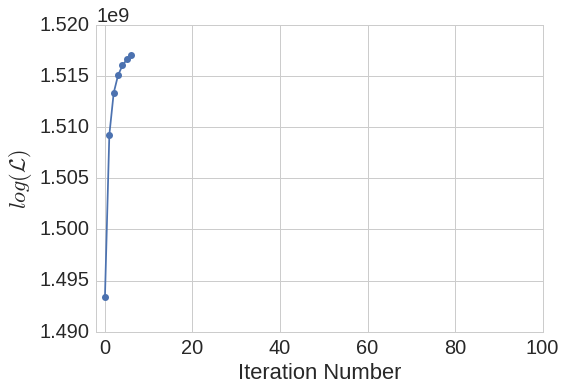

In [72]:
plt.plot((-np.array(llSt) - np.min(-np.array(llSt)))[1:],'o-')
#plt.xscale('log')
#plt.yscale('log')

plt.xlabel('Iteration Number')
plt.ylabel('$log(\mathcal{L})$')
#plt.gca().get_yaxis().get_major_formatter().set_scientific(True)
#plt.xlim(0,100)
plt.xlim(-2,100)

In [103]:
params['l']

[array([ 0.00491221]), array([ 0.00164973]), array([ 0.00392628])]

In [ ]:
lap_post_unnorm(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons)

In [7]:
"""n_timePoints = y[0].shape[1]
n_neurons = y[0].shape[0]
C = params['C']; d = params['d']; t = params['t']
C_big = pGPFA._util.make_Cbig(C,n_timePoints)

nDims = C.shape[1]

K_big,_ = pGPFA._util.make_Kbig(params,params['t'],nDims,epsNoise=1e-3)
K_bigInv = np.linalg.inv(K_big+ np.eye(K_big.shape[0])*1e-3)
lapRes = []
for trl_idx in range(params['nTrials']):
    #trl_idx = 4
    print trl_idx
    x = params['latent_traj'][trl_idx]
    xbar = pGPFA._util.make_xbar(x)
    ybar = pGPFA._util.make_ybar(y[trl_idx])
    resLap = op.minimize(
            fun = pGPFA._lapinf.lap_post_unNorm,
            x0 = x,
            method='Newton-CG',
            args = (ybar, C_big, d, K_bigInv,params['t'],n_neurons),
            jac = pGPFA._lapinf.lap_post_grad,
            hess = pGPFA._lapinf.lap_post_hess,
            options = {'disp': True,'maxiter': 500,'xtol':1e-16
            })

    #print pGPFA._lapinf.lap_post_unNorm(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons)
    #pGPFA._lapinf.lap_post_grad(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons)
    #pGPFA._lapinf.lap_post_hess(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons)
"""
print 

In [101]:
n_timePoints = y[0].shape[1]
n_neurons = y[0].shape[0]
C = params['C']; d = params['d']; t = params['t']
C_big = pGPFA._util.make_Cbig(C,n_timePoints)

nDims = C.shape[1]

K_big,_ = pGPFA._util.make_Kbig(params,params['t'],nDims,epsNoise=1e-3)
K_bigInv = np.linalg.inv(K_big+ np.eye(K_big.shape[0])*1e-3)
lapRes = []

trl_idx = 48
x = params['latent_traj'][trl_idx]
xbar = pGPFA._util.make_xbar(x)
ybar = pGPFA._util.make_ybar(y[trl_idx])

print pGPFA._lapinf.lap_post_unNorm(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons)
pGPFA._lapinf.lap_post_grad(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons)
pGPFA._lapinf.lap_post_hess(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons)

[[-68806.46927051]]


array([[  1.71766950e+03,  -4.32528734e+02,  -4.30572632e+02, ...,
         -1.89131860e+01,   0.00000000e+00,   0.00000000e+00],
       [ -4.32528734e+02,   9.58759387e+02,   6.45966006e+02, ...,
          0.00000000e+00,  -2.42288240e-02,   0.00000000e+00],
       [ -4.30572632e+02,   6.45966006e+02,   1.27491135e+03, ...,
          0.00000000e+00,   0.00000000e+00,  -6.65201260e-05],
       ..., 
       [ -1.89131860e+01,   0.00000000e+00,   0.00000000e+00, ...,
          1.79047721e+03,  -3.83669114e+02,  -1.78490327e+02],
       [  0.00000000e+00,  -2.42288240e-02,   0.00000000e+00, ...,
         -3.83669114e+02,   7.52863328e+02,   2.24977055e+02],
       [  0.00000000e+00,   0.00000000e+00,  -6.65201260e-05, ...,
         -1.78490327e+02,   2.24977055e+02,   7.83622732e+02]])

In [81]:

pGPFA._lapinf.lap_post_unNorm(y,params)

TypeError: lap_post_unNorm() takes exactly 7 arguments (2 given)

In [34]:
st = time.time()
Cdinf = pGPFA.EM.M_step(y,params)
print Cdinf['logL']
print time.time() -st

-323902.964667
78.3481550217


In [9]:
-1378463.94284

-1378463.94284

In [10]:
params['C'] = Cdinf['Cinf']
params['d'] = Cdinf['dinf']

NameError: name 'Cdinf' is not defined

In [ ]:
for i in range(3):
    print "iteration: %s" %i,
    lapinfres = pGPFA.EM.E_step(y,params)
    print lapinfres['logL'],
    params['post_cov_Cd'] = lapinfres['post_cov_Cd']
    params['latent_traj'] = lapinfres['post_mean']
    params['post_cov_GP'] = lapinfres['post_cov_GP']
    Cdinf = pGPFA.EM.M_step(y,params)
    print Cdinf['logL'],
    params['C'] = Cdinf['Cinf']
    params['d'] = Cdinf['dinf']
    precomp = pGPFA._gpinf.precompute_gp(params,lapinfres)
    for dim in range(nD):
        r = op.minimize(pGPFA._gpinf.GP_timescale_Cost,
                1,
                args=precomp[dim])
        
        params['l'][dim] = (1/np.exp(r.x))**(0.5)
    print 'l',params['l']

iteration: 0

In [20]:
lapinfres['post_cov_Cd'][0].shape

(120, 3, 3)

In [76]:
import scipy as sp
trl = 0

U,D,V = sp.linalg.svd(params['C'])
xSVD = (np.dot(np.diag(D),V.T).dot(params['latent_traj'][trl]))

In [77]:
U,D,V = sp.linalg.svd(true_params['C'])
xSVD_true = (np.dot(np.diag(D),V.T).dot(true_params['latent_traj'][trl]))

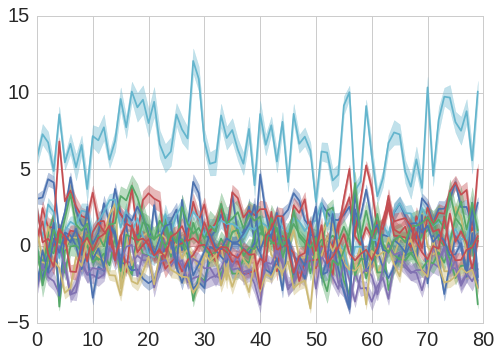

In [78]:
clrs = seaborn.color_palette(n_colors=nD)
for i in range(nD):
    x = params['latent_traj'][trl][i].T
    std2 = 6*np.sqrt(np.diag(lapinfres['post_cov_GP'][trl][i]))
    plt.plot(x,color=clrs[i])
    plt.fill_between(range(n_timePoints),x-std2, x +std2,color=clrs[i],alpha=.4)

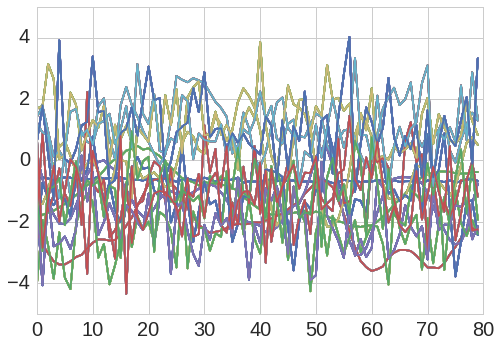

In [79]:
for i in range(nD):
    plt.plot(true_params['latent_traj'][trl].T)

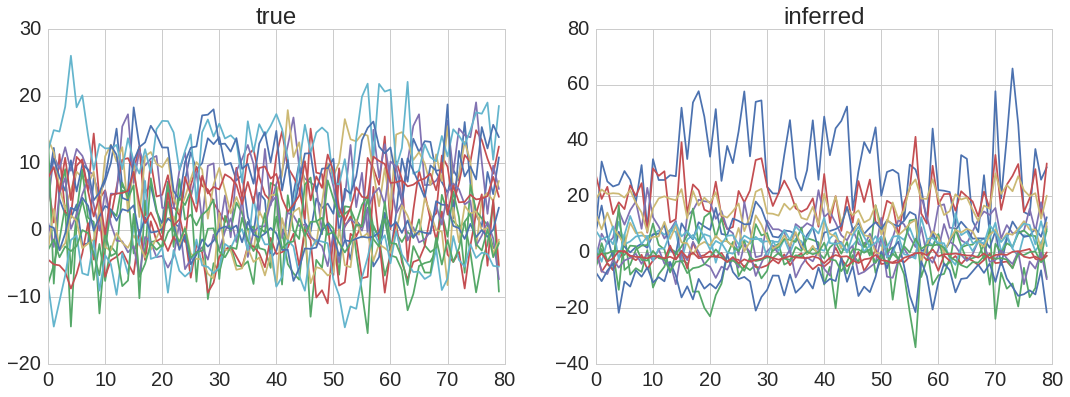

In [80]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.title('true')
for i in xSVD_true:
    plt.plot(i)
    
plt.subplot(1,2,2)
plt.title('inferred')
for i in xSVD:
    plt.plot(i)
    

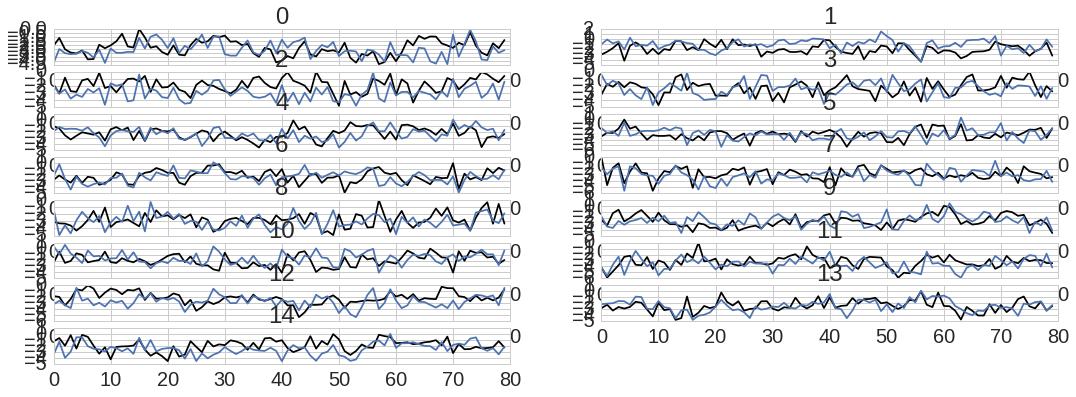

In [81]:
plt.figure(figsize=(18,6))

for i in range(nD):
    plt.subplot(8,2,i+1)
    plt.title(i)
    zscore_xsvd_true = (xSVD_true[i]-np.max(xSVD_true[i]))/np.std(xSVD_true[i])
    plt.plot(zscore_xsvd_true,'k')
    #plt.plot(true_params['latent_traj'][trl][i].T)
    #plt.plot(params['latent_traj'][trl][i].T)
    if np.corrcoef(xSVD_true[i],xSVD[i])[0,1]<0:
        rev = -1
    else:
        rev = 1
    
    zscore_xsvd = rev*(xSVD[i]-np.max(xSVD[i]))/np.std(xSVD[i])
    offset = np.min(zscore_xsvd_true) - np.min(zscore_xsvd)
    plt.plot(offset + rev*(xSVD[i]-np.max(xSVD[i]))/np.std(xSVD[i]),label='inferred')
    

In [335]:
#Dims = 2
#_timePoints = 68
#ost_cov_by_latent = np.zeros([nDims,n_timePoints,n_timePoints])
#or i in range(nDims):
#   post_cov_by_latent[i] = lapinfres['post_cov'][i*n_timePoints:(i+1)*n_timePoints,i*n_timePoints:(i+1)*n_timePoints]


In [41]:
#lapinfres['post_cov_GP'] = post_cov_by_latent

In [42]:
precomp = pGPFA._gpinf.precompute_gp(params,lapinfres)

In [43]:
pGPFA._gpinf.GP_timescale_Cost(.1,precomp[0])

-169.89175516383875

In [44]:
MStepGPtimescaleCost(.1,precomp[0])

-169.89175516383875

In [70]:
%%timeit
r = op.minimize(pGPFA._gpinf.GP_timescale_Cost,
            .46,
            args=precomp[0])
#print r

10 loops, best of 3: 101 ms per loop


In [56]:
(1/np.exp(r.x))**(0.5)

array([ 0.79091238])

In [217]:
def GP_timescale_Cost(tav,precomp):
    tavE = np.exp(tav)
    n_timePoints = precomp['T']

    temp1 = (1-1e-3)*np.exp(-precomp['difSq']*tavE*.5)
    K = temp1 + 1e-3*np.eye(n_timePoints)
    s,logdet = np.linalg.slogdet(K)
    logdet_K = logdet*s
    Kinv = np.linalg.inv(K)

    Kinv_vec = np.reshape(Kinv,n_timePoints**2)
    tempSum_vec = np.reshape(precomp['PautoSum'][1],n_timePoints**2)

    f = .5*logdet_K + .5*np.dot(tempSum_vec,Kinv_vec)
    return f


In [8]:
def MStepGPtimescaleCost_grad(p, precomp):
    '''
    Function written by Byron, Yu in 2009 for the GPFA model. 
    The timescale constant cost function is exactly the same in the P-GPFA case. 
    Translated to Python by Hooram Nam 2015
    '''
    
    epsNoise = 1e-3
    T = precomp['T']
    
    temp = (1-epsNoise)*np.exp(-np.exp(p)/2*precomp['difSq'])
    K = temp + epsNoise*np.eye(T)
    dKdgamma = -0.5*temp*precomp['difSq']
    
    dEdgamma = 0
    f = 0

    Thalf = int(np.ceil(T/2))
    Kinv = np.linalg.inv(K)
    sign, logdet = np.linalg.slogdet(K)
    logdet_K = sign*logdet

    KinvM = np.dot(Kinv[:Thalf,:],dKdgamma)
    KinvMKinv = np.dot(KinvM,Kinv)
    
    dg_KinvM = np.diag(KinvM)
    tr_KinvM = 2*sum(dg_KinvM) - T%2*dg_KinvM[-1]

    mkr = int(np.floor(0.5*T**2))
    
    KinvVec = np.reshape(Kinv,T*T)
    PSallVec = np.reshape(precomp['PautoSum'],T*T)
    PS1vec = PSallVec[:mkr]
    PS2vec = PSallVec[mkr:]
    PS2vec = PS2vec[::-1]

    KinvMKinvVec = np.reshape(KinvMKinv, mkr)
    
    dEdgamma = -0.5*precomp['numTrials']*tr_KinvM + 0.5*np.dot(PS1vec,KinvMKinvVec) + 0.5*np.dot(PS2vec,KinvMKinvVec)
    f = -0.5* precomp['numTrials']*logdet_K - 0.5*np.dot(PSallVec,KinvVec)

    return -dEdgamma*np.exp(p)

In [9]:

def MStepGPtimescaleCost(p, precomp):
    '''
    Function written by Byron & Yu 2009 for the GPFA model. 
    The timescale constant cost function is exactly the same in the P-GPFA case. 
    Translated to Python by Hooram Nam 2015
    '''
    epsNoise = 1e-3
    T = precomp['T']

    temp = (1-epsNoise)*np.exp(-np.exp(p)/2*precomp['difSq'])
    K = temp + epsNoise*np.eye(T)

    Thalf = int(np.ceil(T/2))
    Kinv = np.linalg.inv(K)
    sign, logdet = np.linalg.slogdet(K)
    logdet_K = sign*logdet


    KinvVec = np.reshape(Kinv,T*T)
    PSallVec = np.reshape(precomp['PautoSum'],T*T)


    f = -0.5* precomp['numTrials']*logdet_K - 0.5*np.dot(PSallVec,KinvVec)

    return -f

In [222]:
GP_timescale_Cost(.1,precomp)

-11.419421457284358

In [223]:
import scipy.optimize as op

In [66]:
%%timeit
res = op.minimize(MStepGPtimescaleCost,
            3,
            args=(precomp[1]),
            jac= MStepGPtimescaleCost_grad,
            options = {'disp': False,'gtol':1e-8},
                  
            )


10 loops, best of 3: 92.6 ms per loop


In [64]:
(1/np.exp(res.x))**(0.5)

array([ 0.7909123])

In [169]:
params['l']

[10, 0.6309573444801932]

In [103]:
K = pGPFA._util.calc_K(x=params['t'],y=params['t'],l=1)

In [219]:
np.allclose(temp2,np.outer(lapinfres['post_mean'][idx],lapinfres['post_mean'][idx]).T)

False

In [228]:
np.outer(lapinfres['post_mean'][idx],lapinfres['post_mean'][idx])

array([[ 0.1532417 ,  0.15518862,  0.14705277, ...,  0.17561912,
         0.19634418,  0.21238097],
       [ 0.15518862,  0.15716028,  0.14892107, ...,  0.17785035,
         0.19883871,  0.21507925],
       [ 0.14705277,  0.14892107,  0.1411138 , ...,  0.16852645,
         0.18841449,  0.20380361],
       ..., 
       [ 0.17561912,  0.17785035,  0.16852645, ...,  0.20126425,
         0.22501573,  0.24339433],
       [ 0.19634418,  0.19883871,  0.18841449, ...,  0.22501573,
         0.25157014,  0.27211763],
       [ 0.21238097,  0.21507925,  0.20380361, ...,  0.24339433,
         0.27211763,  0.29434337]])

In [229]:
idx = 1
temp2 =np.outer(lapinfres['post_mean'][idx],lapinfres['post_mean'][idx])#np.dot(np.array([lapinfres['post_mean'][idx]]).T,np.array([lapinfres['post_mean'][idx]]))
precomp = temp2 + lapinfres['post_cov_GP'][idx]

In [226]:
def getLL(tav,precomp):
    tav = np.exp(tav)
    K = pGPFA._util.calc_K(x=params['t'],y=params['t'],l=tav)
    K += np.eye(K.shape[0])*1e-3
    det,s = np.linalg.slogdet(K)
    t1 = .5*det*s
    invK = np.linalg.inv(K)
    t2 = .5*np.trace(np.dot(invK,precomp))
    
    return -(-t1-t2)

In [227]:
getLL(.1,precomp)

TypeError: unsupported operand type(s) for *: 'float' and 'dict'

In [248]:
temp1,s = np.linalg.slogdet(K)
temp2 =np.dot(np.array([lapinfres['post_mean'][0]]).T,np.array([lapinfres['post_mean'][0]]))
temp3 = np.linalg.inv(K)
LL = .5*(temp1*s + np.trace(np.dot(temp3,(lapinfres['post_cov_GP'][0] + temp2))))
#5*temp1*s + .5*np.trace(np.linalg.inv(K).dot(lapinfres['post_cov_GP'][0] +np.dot(lapinfres['post_cov_alt'],.5*temp1*s + .5*np.trace(np.linalg.inv(K).dot(lapinfres['post_cov_GP'][0] + temp2)))))
print LL

-168.715847463


In [249]:
import scipy.optimize as op

In [250]:
res = op.minimize(getLL,
            1,
            precomp)
print res

      fun: nan
 hess_inv: array([[1]])
      jac: array([ nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 126
      nit: 1
     njev: 42
   status: 2
  success: False
        x: array([-464286.765625])


In [226]:
true_params['l']

[10, 0.6309573444801932]

In [227]:
np.exp(res.x)

array([  2.21833696e+197])

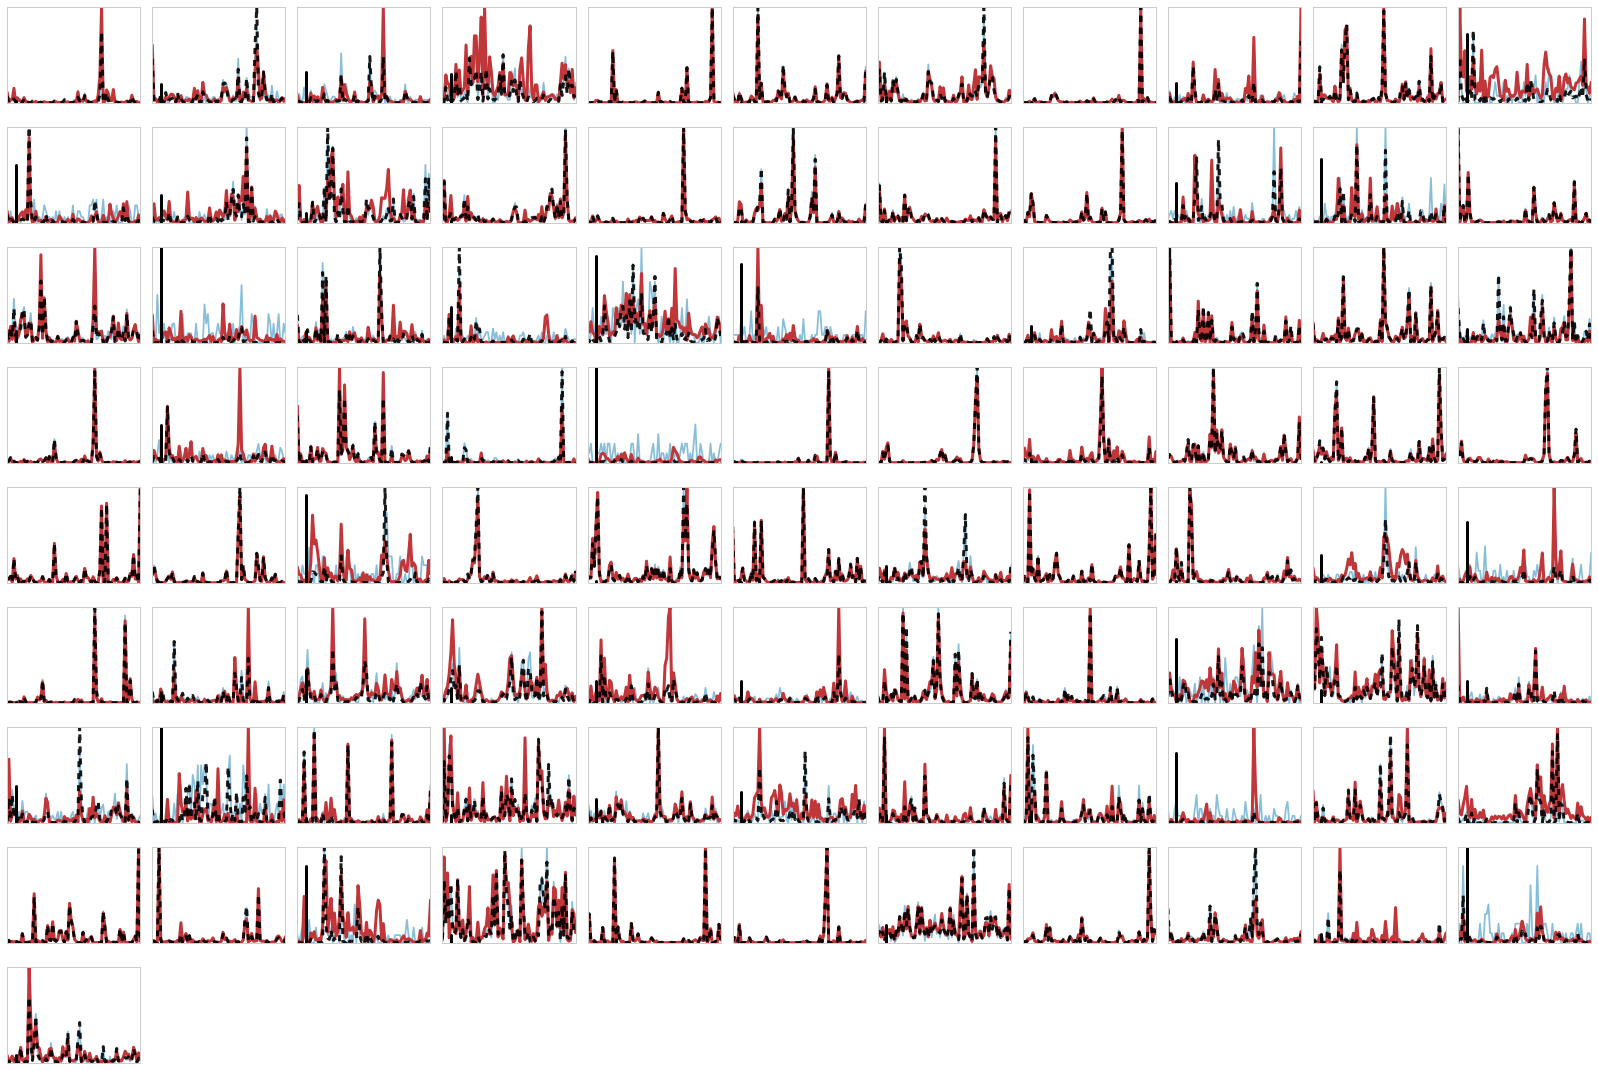

In [82]:
plt.figure(figsize=(22,18))
n_neurons = y[0].shape[0]
clrs = seaborn.color_palette('RdBu',n_colors=6)
#plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= np.ceil(np.sqrt(n_neurons))+1,np.ceil(np.sqrt(n_neurons))+1

tt = 0

trl = 0
C = params['C']
x = params['latent_traj']

true_rates = np.exp(true_params['C'].dot(true_params['latent_traj'][trl]).T+true_params['d']).T
inf_rates = np.exp(params['C'].dot(params['latent_traj'][trl]).T+params['d']).T
for real,sim in zip(true_rates,
                    inf_rates):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[trl][tt],color=clrs[-2])

        plt.plot(sim,color=clrs[0],linewidth=3)
        plt.plot(real,'--',color='k',linewidth=3,alpha=0.9)

        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        plt.plot([5,5],[0,10],linewidth=3,color='k')
        #plt.ylim()
        #plt.legend()
        
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)


In [67]:
np.max(true_params['C'])

1.57790157940335

In [68]:
np.random.poisson([5,1,1])

array([4, 0, 1])

In [69]:
from scipy.signal import savgol_filter

NameError: name 'trl' is not defined

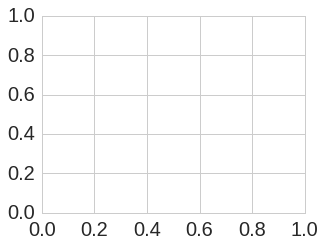

In [12]:
plt.figure(figsize=(16,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    idx = np.random.randint(0,n_neurons)
    plt.plot(y[trl][idx],'-o',color=clrs[-2],label='spikes/bin')
    #plt.plot(savgol_filter(y[trl][idx],17,3),label='filtered')
    plt.plot(inf_rates[idx],color=clrs[0],linewidth=3,label='inferred rate')
    plt.plot(true_rates[idx],'--',color='k',linewidth=3,alpha=0.9,label='true rate')
    plt.legend(loc='best')


In [140]:
ccst = []; ccst2 = []
for idx in range(true_rates.shape[0]):

    ccst.append(
        np.corrcoef(true_rates[idx],savgol_filter(y[trl][idx],17,3))[0,1]
        )
    
    ccst2.append(
                 np.corrcoef(true_rates[idx],inf_rates[idx])[0,1])

(-0.5, 1)

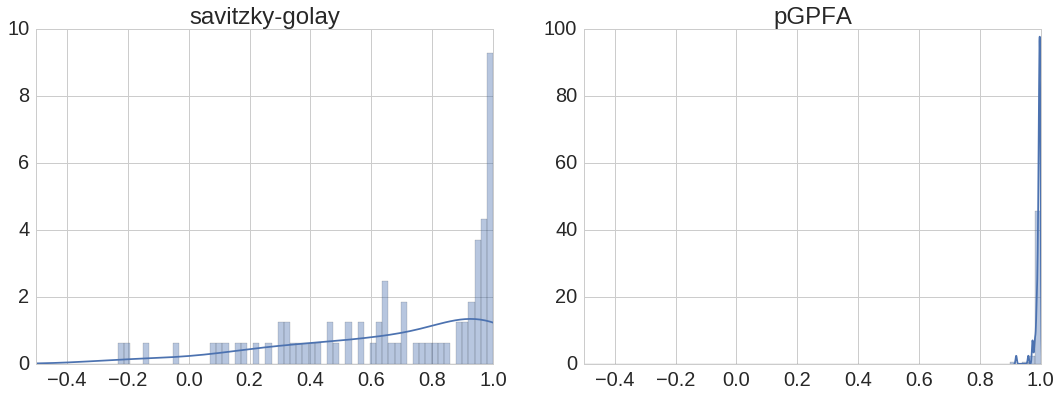

In [146]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
seaborn.distplot(ccst,bins=np.linspace(-1,1,num=100))
plt.xlim(-.5,1)
plt.title('savitzky-golay')
plt.subplot(1,2,2)
plt.title('pGPFA')

seaborn.distplot(ccst2,bins=np.linspace(-1,1,num=100))
plt.xlim(-.5,1)

(-1, 1)

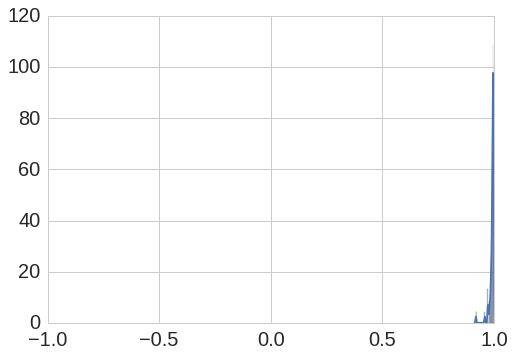

In [135]:
seaborn.distplot(ccst2)
plt.xlim(-1,1)

In [398]:
test_arr = np.zeros([400,true_rates[idx].shape[0]])
for i in range(400):
    test_arr[i] = np.random.poisson(true_rates[idx])
    #plt.plot(test_arr[i])

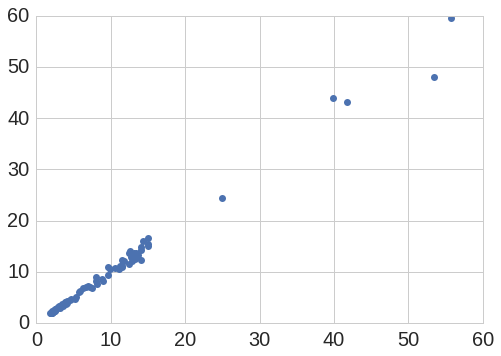

In [399]:
plt.plot(np.mean(test_arr,axis=0),np.var(test_arr,axis=0),'o')